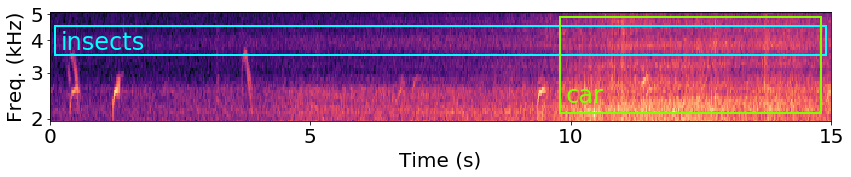

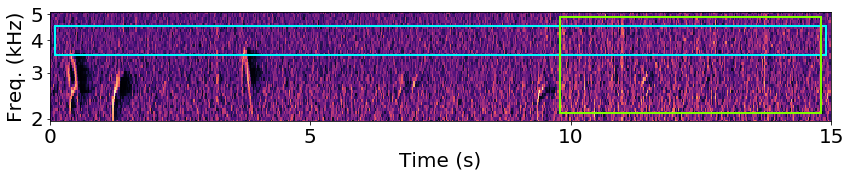

In [30]:
import librosa
import librosa.display
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy

data_dir = '/beegfs/vl1019/spl2018_datasets/BirdVox-pcen'
wav_names = os.listdir(data_dir)
wav_paths = sorted([os.path.join(data_dir, x) for x in wav_names])
n_files = len(wav_paths)

settings = {
    "fmin": 50,
    "fmax": 10000,
    "hop_length": 512,
    "n_fft": 2048,
    "n_mels": 128,
    "sr": 22050,
    "win_length": 1024,
    "window": "hann",
    "T": 0.05,
    "alpha": 0.95,
    "delta": 2.0,
    "r": 0.5,
    "eps": 1e-10}

file_id = 5
wav_path = wav_paths[file_id]
waveform, fs = librosa.load(wav_path, sr=22050)


# Compute Short-Term Fourier Transform (STFT).
stft = librosa.stft(
    waveform,
    n_fft=settings["n_fft"],
    win_length=settings["win_length"],
    hop_length=settings["hop_length"],
    window=settings["window"])

# Compute squared magnitude coefficients.
abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)

# Gather frequency bins according to the Mel scale.
E = librosa.feature.melspectrogram(
    y=None,
    S=abs2_stft,
    sr=settings["sr"],
    n_fft=settings["n_fft"],
    n_mels=settings["n_mels"],
    htk=True,
    fmin=settings["fmin"],
    fmax=settings["fmax"])


PCEN = librosa.pcen(
    S=E,
    time_constant=settings["T"],
    sr=settings["sr"],
    hop_length=settings["hop_length"],
    gain=settings["alpha"],
    power=settings["r"],
    bias=settings["delta"],
    eps=settings["eps"])



figsize = (14, 2.0)

melmin = 64
melmax = 101
tmin = int(25*settings["sr"]/settings["hop_length"])
tmax = int(40*settings["sr"]/settings["hop_length"])


%matplotlib inline
fig = plt.figure(figsize=(14, 2))
E_dB = 10 * np.log10(E[melmin:melmax,tmin:tmax])
fmin = librosa.mel_frequencies(
    n_mels=settings["n_mels"],
    fmin=settings["fmin"], fmax=settings["fmax"])[melmin]
fmax = librosa.mel_frequencies(
    n_mels=settings["n_mels"],
    fmin=settings["fmin"], fmax=settings["fmax"])[melmax]
librosa.display.specshow(E_dB,
    y_axis='mel', x_axis="time",
    sr=settings["sr"], hop_length=settings["hop_length"],
    fmin=fmin, fmax=fmax)
rect_insects = matplotlib.patches.Rectangle((0.1, 3500.0),
    14.8, 1000.0, edgecolor='#00FFFF', linewidth=2.0, facecolor='none')
text_insects = plt.text(0.2, 3500.0, 'insects', size=24.0,
    color='#00FFFF', va='bottom',
    bbox=dict(facecolor='k', edgecolor='none', alpha=0.0))
rect_car = matplotlib.patches.Rectangle((9.8, 2100.0),
    5.0, 2800.0, edgecolor='#80FF00', linewidth=2.0, facecolor='none')
text_car = plt.text(9.9, 2200.0, 'car', size=24.0,
    color='#80FF00', va='bottom',
    bbox=dict(facecolor='k', edgecolor='none', alpha=0.0))
plt.gcf().get_axes()[0].add_patch(rect_insects)
plt.gcf().get_axes()[0].add_patch(rect_car)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Freq. (kHz)", fontsize=20)
plt.xticks(np.linspace(0, 15, 4))
plt.gca().set_xticklabels(np.linspace(0, 15, 4).astype('int'), fontsize=20)
plt.yticks(np.linspace(2000, 5000, 4))
plt.gca().set_yticklabels([2, 3, 4, 5], fontsize=20)
plt.minorticks_off()
fig.savefig('logE_spectrogram.eps',
    transparent=True, bbox_inches="tight")




fig = plt.figure(figsize=(14, 2))
fmin = librosa.mel_frequencies(
    n_mels=settings["n_mels"],
    fmin=settings["fmin"], fmax=settings["fmax"])[melmin]
fmax = librosa.mel_frequencies(
    n_mels=settings["n_mels"],
    fmin=settings["fmin"], fmax=settings["fmax"])[melmax]
librosa.display.specshow(PCEN[melmin:melmax,tmin:tmax],
    y_axis='mel', x_axis="time",
    sr=settings["sr"], hop_length=settings["hop_length"],
    fmin=fmin, fmax=fmax)
rect_insects = matplotlib.patches.Rectangle((0.1, 3500.0),
    14.8, 1000.0, edgecolor='#00FFFF', linewidth=2.0, facecolor='none')
rect_car = matplotlib.patches.Rectangle((9.8, 2100.0),
    5.0, 2800.0, edgecolor='#80FF00', linewidth=2.0, facecolor='none')
plt.gcf().get_axes()[0].add_patch(rect_insects)
plt.gcf().get_axes()[0].add_patch(rect_car)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Freq. (kHz)", fontsize=20)
plt.xticks(np.linspace(0, 15, 4))
plt.gca().set_xticklabels(np.linspace(0, 15, 4).astype('int'), fontsize=20)
plt.yticks(np.linspace(2000, 5000, 4))
plt.gca().set_yticklabels([2, 3, 4, 5], fontsize=20)
plt.minorticks_off()
fig.savefig('PCEN_spectrogram.eps',
    transparent=True, bbox_inches="tight")

In [ ]:

E_ravel = E.ravel()
log_E_ravel = np.log(E_ravel)
PCEN_ravel = PCEN.ravel()
BC_ravel, lmbda = scipy.stats.boxcox(E_ravel)

%matplotlib inline
fig = plt.figure()
hist_x = plt.hist(
    (log_E_ravel - np.mean(log_E_ravel)) / np.std(log_E_ravel), bins=500);
xgauss = np.linspace(-4, 4, 500)
hist_step = np.diff(hist_x[1])[0]
gaussmax = len(E_ravel)/np.sqrt(2*np.pi) * hist_step
ygauss = gaussmax * np.exp(-(xgauss*xgauss)/2)
plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
plt.xlim([-4,4])
plt.ylim([0, 2000])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(labelleft="off", left="off")
fig.savefig('logE_histogram.eps', transparent=True)

fig = plt.figure()
plt.hist((BC_ravel - np.mean(BC_ravel)) / np.std(BC_ravel), bins=500);
plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
plt.xlim([-4,4])
plt.ylim([0, 2000])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(labelleft="off", left="off")
fig.savefig('BC_histogram.eps', transparent=True)

plt.figure(frameon=False)
plt.hist((PCEN_ravel - np.mean(PCEN_ravel)) / np.std(PCEN_ravel), bins=500);
plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
plt.xlim([-4,4])
plt.ylim([0, 2000])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(labelleft="off", left="off")
fig.savefig('PCEN_histogram.eps', transparent=True)